In [1]:
import json
import sys
sys.path.append('../simulated_fqi/')
import seaborn as sns
import tqdm
import matplotlib.pyplot as plt 
import numpy as np
import torch
import random
import shap
import configargparse
import torch
import torch.optim as optim
import scipy
from environments import Gridworld
from models.agents import NFQAgent
from models.networks import NFQNetwork, ContrastiveNFQNetwork
from util import get_logger, close_logger, load_models, make_reproducible, save_models
import matplotlib.pyplot as plt
import numpy as np
import itertools
from train import fqi
import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from environments import CartPoleRegulatorEnv
from scipy.stats import norm, multivariate_normal
from sklearn.linear_model import LinearRegression
from irl_gridworld import find_feature_expectations, plot_reward, norm, find_valid_actions, generate_rollout, generate_policy_rollout, runLinearFQI, l2_norm
from multiprocessing import Pool
from matplotlib.colors import LogNorm, Normalize
plt.rcParams.update({'font.size': 10})
from scipy.stats import multivariate_normal
import pickle

In [2]:
NUM_SAMPLES = 50

In [3]:
# Reward params
def generate_states(r_pos, r_theta, samples, plot=False):
    x_threshold = 2.4
    theta_success = math.pi/2
    cart_pos = [i/10 for i in range(-25, 25)]
    angles = [i/10 for i in range(-16, 26)]
    demonstration_density = np.zeros((len(angles), len(cart_pos)))
    num_samples = 0
    samples = multivariate_normal.rvs(mean=[0, 0], cov=[[((r_pos*2)*(r_pos*2))/2, 0], [0, ((r_theta*2)*(r_theta*2))/2]], size=samples)
    #while num_samples < samples:
    for i in range(samples.shape[0]):
        # Samples from gaussian
        #pos = np.round(np.random.normal(MEAN_POS, SIGMA_POS), 1)
        #theta = np.round(np.random.normal(MEAN_ANG, SIGMA_ANG), 1)
        
        # Samples from uniform
        #pos = np.round(np.random.uniform(-2.3, 2.3), 1)
        
        # Samples from diagonal 2-D Gaussian
#         sample = multivariate_normal.rvs(mean=[0, 0], cov=[[3, 0], [0, 1]], size=1)
        sample = samples[i]
        pos = np.round(sample[0], 1)
        theta = np.round(sample[1], 1)
        #position_indicator = (pos <=  r_pos) and (pos >= -r_pos)
        position_indicator = (pos <=  x_threshold) and (pos >= -x_threshold)
        #theta_indicator = (theta <= r_theta) and (theta >= -r_theta)
        theta_indicator = (theta <= theta_success) and (theta >= -theta_success)
        if position_indicator and theta_indicator:
            x_ind = cart_pos.index(pos)
            theta_ind = angles.index(theta)

            demonstration_density[theta_ind, x_ind] += 1
            num_samples += 1
    if plot:
#         plt.figure(figsize=(18, 7))
#         ax = sns.heatmap(demonstration_density, xticklabels=cart_pos, yticklabels=angles)
#         plt.xlabel("Cart Position")
#         plt.ylabel("Pole Angle (radians)")
#         plt.title(str(r_pos) + " " + str(r_theta) + " " + str(num_samples))
#         ax.invert_yaxis()
        
        return demonstration_density, cart_pos, angles

    states = []
    for i in range(demonstration_density.shape[0]):
        for j in range(demonstration_density.shape[1]):
            count = demonstration_density[i][j]
            for kk in range(int(count)):
                states.append([[cart_pos[j], angles[i]], [r_pos, r_theta]])
    return states

In [4]:
def generate_training():
    reward_pos = [i/10 for i in range(5, 25, 2)] # use a step of 2
    reward_ang = [i/10 for i in range(1, 15, 2)] # use a step of 2
    behavior = []
    for i, pos in enumerate(reward_pos):
        for j, ang in enumerate(reward_ang):
            states = generate_states(pos, ang, NUM_SAMPLES)
            behavior.extend(states)
    return behavior

In [5]:
observations = generate_training()

In [6]:
def distance_r(r, r_prime):
    h_prime = 0.3
    dist_pos = np.absolute(r[0] - r_prime[0])
    dist_ang = np.absolute(r[1] - r_prime[1])
    dist = dist_pos + dist_ang
    return np.exp(-(np.power(dist, 2)/(2*h_prime)))

def distance_points(p1, p2):
    h=0.08
    dist = scipy.spatial.distance.euclidean(p1, p2) #+ scipy.spatial.distance.euclidean(p1[1], p2[1])
    return np.exp(-np.power(dist, 2)/(2*h))

def distance_rewards(r_k, observations):
    sum_diff = 0
    for sample in observations:
        r = sample[1]
        sum_diff += distance_r(r_k, r)
    return sum_diff

def conditional_dist(s_i, dataset, reward):
    sum = 0
    dist_rewards = distance_rewards(reward, dataset)
    for s_j in dataset:
        weight = distance_r(reward, s_j[1]) / dist_rewards
        dist = distance_points(s_i, s_j[0])
        est = dist * weight 
        sum += est
    return sum

def estimate_expert_posterior(r_k, behavior_opt, observations):
    post = 0
    dist_rewards = distance_rewards(r_k, observations)
    for s_i in behavior_opt:
        sum_si = 0
        for s_j in observations:
            weight = distance_r(r_k, s_j[1]) / dist_rewards
            likelihood = distance_points(s_i[0], s_j[0]) * weight
            sum_si += likelihood
        if sum_si == 0:
            post += np.log(0.000000000001)
        else:
            post += np.log(sum_si)
    return post

# Conditional density experiment

In [8]:
def heatmap_dataset_conditional_density_posterior(reward):
    demonstration_density, cart_pos, angles = generate_states(reward[0], reward[1], 1000, plot=True)
    cart_pos = [i/10 for i in range(-25, 25)]
    cart_angles = [i/10 for i in range(-16, 26)]
    heatmap_conditional = np.zeros((len(cart_angles), len(cart_pos)))
    for i, ang in enumerate(tqdm.tqdm(cart_angles)):
        for j, pos in enumerate(cart_pos):
            state = [pos, ang]
            c_est = conditional_dist(state, observations, reward)
            heatmap_conditional[i, j] += c_est
    fig, axs = plt.subplots(3, 1, figsize=(18, 14), constrained_layout=True)
    sns.heatmap(demonstration_density, xticklabels=cart_pos, yticklabels=angles, ax=axs[0])
    axs[0].set_xlabel("Cart Position")
    axs[0].set_ylabel("Pole Angle (radians)")
    axs[0].set_title("Demonstration density for reward: " + str(reward))
    axs[0].invert_yaxis()

    sns.heatmap(heatmap_conditional, xticklabels=cart_pos, yticklabels=cart_angles, ax=axs[1])
    axs[1].invert_yaxis()
    axs[1].set_xlabel("Cart Position")
    axs[1].set_ylabel("Pole Angle (radians)")
    axs[1].set_title("Conditional density wrt reward: " + str(reward))

    reward_pos = [i/10 for i in range(5, 25)]
    reward_ang = [i/10 for i in range(1, 15, 2)]
    behavior_opt = generate_states(reward[0], reward[1], NUM_SAMPLES, plot=False)
    heatmap_posterior = np.zeros((len(reward_ang), len(reward_pos)))
    for i, pos in enumerate(tqdm.tqdm(reward_pos)):
        for j, ang in enumerate(reward_ang):
            r_k = [pos, ang]
            post = estimate_expert_posterior(r_k, behavior_opt, observations)
            heatmap_posterior[j, i] = post

    sns.heatmap(heatmap_posterior, xticklabels=reward_pos, yticklabels=reward_ang, ax=axs[2])
    axs[2].invert_yaxis()
    axs[2].set_xlabel("X Success Range")
    axs[2].set_ylabel("Angle Success Range")
    axs[2].set_title("Expert posterior, true reward=" + str(reward))
    return heatmap_posterior, reward_pos, reward_ang

100%|██████████| 20/20 [04:27<00:00, 13.37s/it]


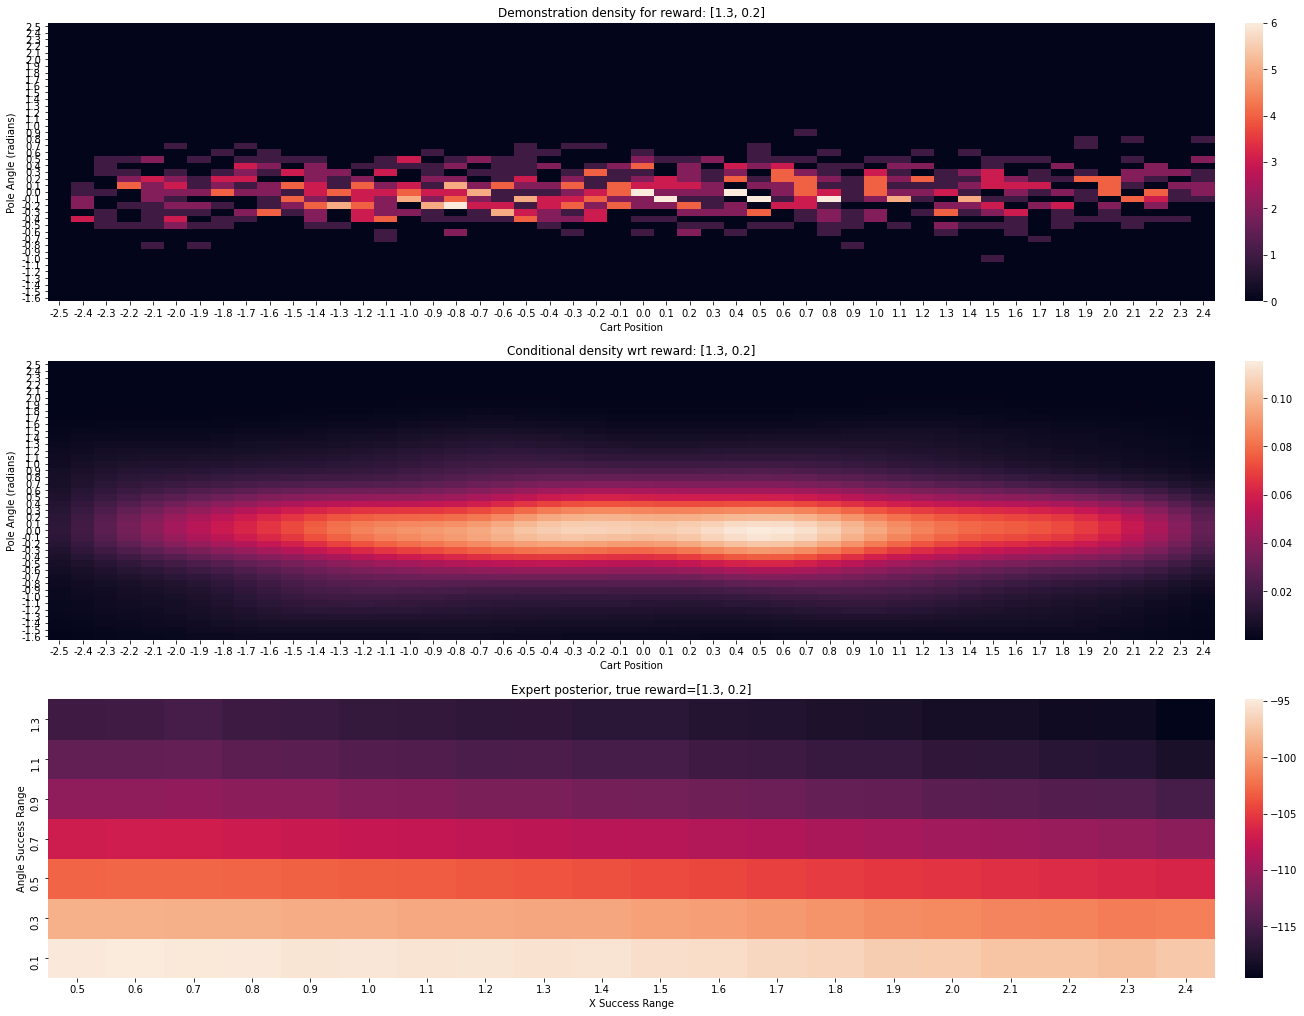

In [9]:
hmap_posterior, reward_pos, reward_ang = heatmap_dataset_conditional_density_posterior([1.3, 0.2])

# Posterior predictive checks
* Sample 1000 times from this posterior
* Check to see if the demonstration density of the mode/top frequency rewards are the same as the original reward

In [55]:
def most_common_reward(hmap_posterior, reward_pos, reward_ang, pct=0.1):
    post = hmap_posterior / np.max(np.abs(hmap_posterior))
    post = np.exp(post)
    post /= np.sum(post)
    
    rewards = np.random.multinomial(1000000, post.flatten())
    rewards = rewards.reshape((len(reward_ang), len(reward_pos)))
    
    evaluations = rewards // 1000
    x = reward_pos
    y = reward_ang
    # xx is the position, yy is the angle
    xx, yy = np.meshgrid(x, y, sparse=True)
    
    reward_fns = []
    for kk, i in enumerate(range(len(reward_pos))):
        for ll, j in enumerate(range(len(reward_ang))):
            r_k = [xx[0][i], yy[j][0]]
            count = evaluations[ll, kk]
            for aa in range(count):
                reward_fns.append(r_k)
    fn_to_count = {}
    for fn in reward_fns:
        if tuple(fn) not in fn_to_count:
            fn_to_count[tuple(fn)] = 0
        fn_to_count[tuple(fn)] += 1
    
    fns = sorted(fn_to_count.items(), key=lambda item: item[1], reverse=True)
    most_common_fns = fns[:int(len(fns)*pct)]
    return_most_common_fns

Text(0.5, 1.0, 'Demonstration density for reward: [1.3, 0.2]')

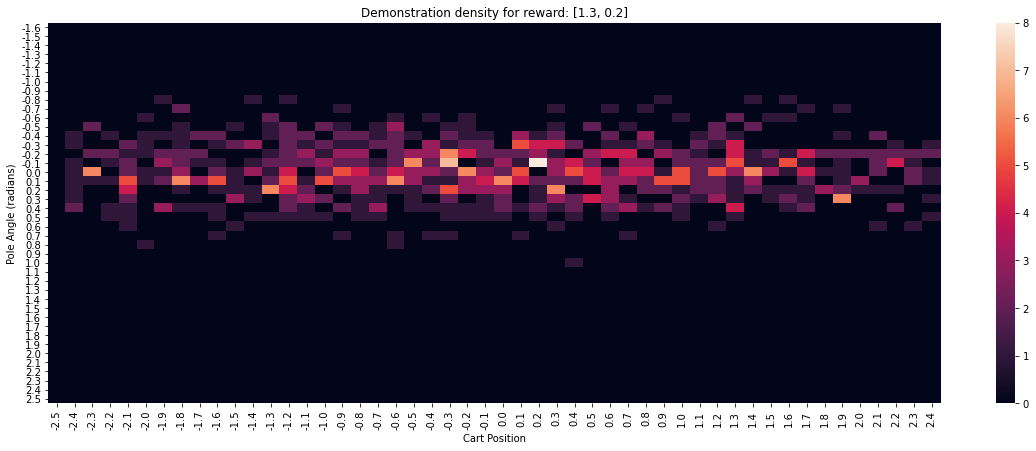

In [52]:
# Original reward
reward = [1.3, 0.2]
fig, axs = plt.subplots(figsize=(20, 7))
demonstration_density, cart_pos, angles = generate_states(reward[0], reward[1], 1000, plot=True)
sns.heatmap(demonstration_density, xticklabels=cart_pos, yticklabels=angles, ax=axs)
axs.set_xlabel("Cart Position")
axs.set_ylabel("Pole Angle (radians)")
axs.set_title("Demonstration density for reward: " + str(reward))

Text(0.5, 1.0, 'Demonstration density for reward: (0.5, 0.1)')

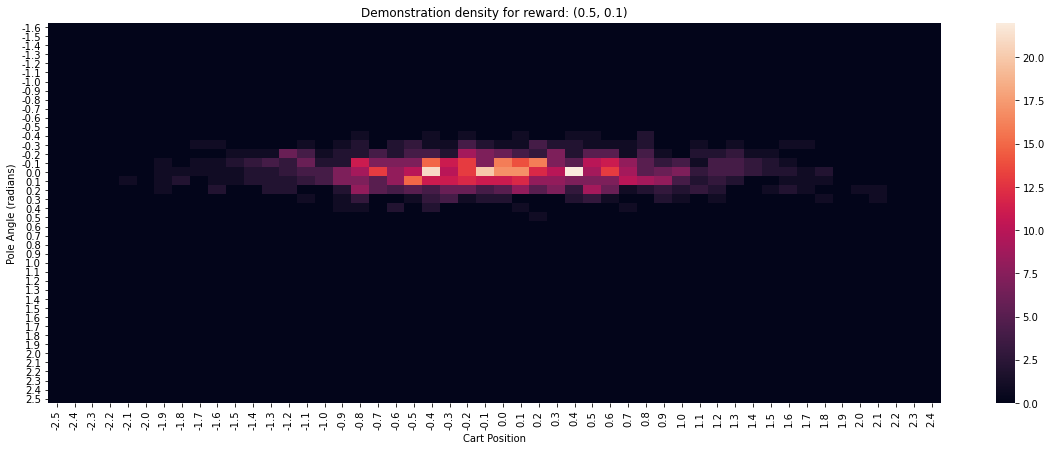

In [53]:
reward = most_common_fns[0][0]
fig, axs = plt.subplots(figsize=(20, 7))
demonstration_density, cart_pos, angles = generate_states(reward[0], reward[1], 1000, plot=True)
sns.heatmap(demonstration_density, xticklabels=cart_pos, yticklabels=angles, ax=axs)
axs.set_xlabel("Cart Position")
axs.set_ylabel("Pole Angle (radians)")
axs.set_title("Demonstration density for reward: " + str(reward))

Text(0.5, 1.0, 'Demonstration density for reward: (0.5, 0.3)')

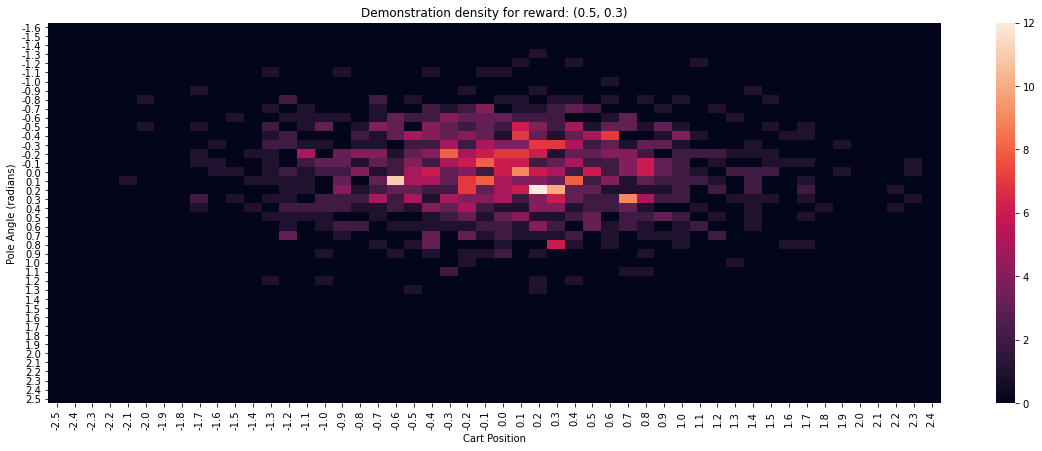

In [54]:
reward = most_common_fns[1][0]
fig, axs = plt.subplots(figsize=(20, 7))
demonstration_density, cart_pos, angles = generate_states(reward[0], reward[1], 1000, plot=True)
sns.heatmap(demonstration_density, xticklabels=cart_pos, yticklabels=angles, ax=axs)
axs.set_xlabel("Cart Position")
axs.set_ylabel("Pole Angle (radians)")
axs.set_title("Demonstration density for reward: " + str(reward))